In [60]:
from data_classes import LAQNData, HealthData, MetData, IncomeData
from ADMS_functions import plot_on_map
from os import path, listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
import zipfile as zpf
import httplib2
from bs4 import BeautifulSoup, SoupStrainer

In [31]:
income = IncomeData()
income_df = income.read("income-raw")
income_metadata_df = income.read("income-metadata")

species = "NO2"
region = "London"
NO2 = LAQNData(species, region)
NO2_df = NO2.read("laqn-raw")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Downloading large artifact laqn-raw:latest, 1407.16MB. 198 files... Done. 0:0:0


In [32]:
income_df.head(3)

,E09000004,E09000028,E09000030,E09000002,E09000024,E09000008,E09000001,E09000011,E09000014,E09000003,...,E09000025,E09000023,E09000018,E09000031,E09000026,E09000029,E09000009,E09000027,E09000021,E09000032
1997-01-01,12101.0,10710.0,13085.0,8410.0,16260.0,10214.0,81474.0,13456.0,14170.0,12621.0,...,5910.0,9226.0,13943.0,10461.0,11555.0,11555.0,12923.0,21860.0,14998.0,13863.0
1998-01-01,12181.0,11160.0,13313.0,8667.0,16620.0,10605.0,89776.0,13518.0,14428.0,13337.0,...,6423.0,9563.0,14162.0,10688.0,11777.0,11899.0,13277.0,22318.0,15227.0,15435.0
1999-01-01,12615.0,12042.0,14068.0,9154.0,17510.0,11418.0,82581.0,14244.0,15279.0,14019.0,...,7143.0,10315.0,14953.0,11377.0,12238.0,12489.0,13990.0,23139.0,15992.0,17124.0


In [33]:
NO2_df.head(3)

,EA1,BN2,A30,BX7,BX1,BP0,CR2,BY7,BT7,BT5,...,WM9,WM0,WL4,WMB,WM5,WM8,WMD,WMC,WMA,WMZ
1996-01-01 00:00:00,52.3,NaN,NaN,NaN,NaN,NaN,49.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 01:00:00,55.8,NaN,NaN,NaN,61.2,65.0,48.3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 02:00:00,62.3,NaN,NaN,NaN,63.1,76.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
london_sites = requests.get("http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json")
london_sites_df = pd.DataFrame(london_sites.json()['Sites']['Site'])
london_sites_df = london_sites_df.loc[london_sites_df["@Latitude"]!=""]
london_sites_df = london_sites_df.loc[london_sites_df["@Latitude"].astype(float)>51]

In [81]:
lat = london_sites_df["@Latitude"].values
lon = london_sites_df["@Longitude"].values

In [82]:
site_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon, lat))

<AxesSubplot:>

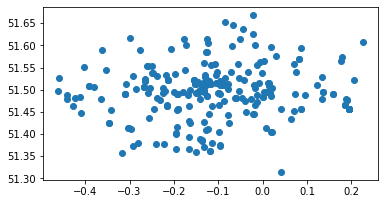

In [83]:
site_gdf.plot()

In [84]:
tmp_folder = f"/home/users/mwlw3/AQmortality/tmp/"

In [85]:
# Get the web links for the borough & ward coordinate data files

web_address = "https://data.london.gov.uk/dataset/i-trees-canopy-ward-data"

status, response = httplib2.Http().request(web_address)
link_dict = {}

for link in BeautifulSoup(response, parse_only=SoupStrainer('a')):
    if link.has_attr('href') and link["href"].split(".")[-1]=="zip":
        link_dict[link['href'].split("/")[-1].split(".")[0]] = f"https://data.london.gov.uk/{link['href']}"

In [51]:
# Download the borough & ward coordinate data files and unzip them

for url in link_dict.values():
    request = requests.get(url)
    filepath = path.join(tmp_folder, "i-Trees", path.basename(url))
    file = open(filepath, 'wb')
    file.write(request.content)
    file.close()
    zpf.ZipFile(filepath, 'r').extractall(path.join(tmp_folder, "i-Trees"))

In [58]:
# Compile a geopandas dataframe of the london wards coordinates

london_wards_gdf = gpd.GeoDataFrame()

for borough in link_dict.keys():
    borough_folder = path.join(tmp_folder, "i-Trees", borough)
    shapefiles = [file for file in listdir(borough_folder) if file.split(".")[-1]=="shp"]
    for shapefile in shapefiles:
        gdf = gpd.read_file(path.join(borough_folder, shapefile))
        if london_wards_gdf.empty:
            london_wards_gdf = gdf
        else:
            london_wards_gdf = pd.concat([london_wards_gdf, gdf])
london_wards_gdf.to_file(path.join(tmp_folder, "london_wards_coordinates", "london_wards_coordinates.shp"))

In [100]:
# Load the geopandas dataframe of the london wards coordinates
london_wards_gdf = gpd.read_file(path.join(tmp_folder, "london_wards_coordinates", "london_wards_coordinates.shp"))

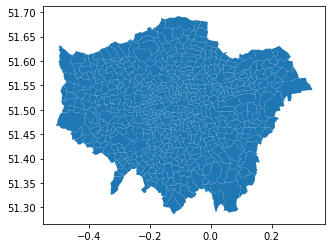

In [101]:
london_wards_gdf.plot()
plt.show()

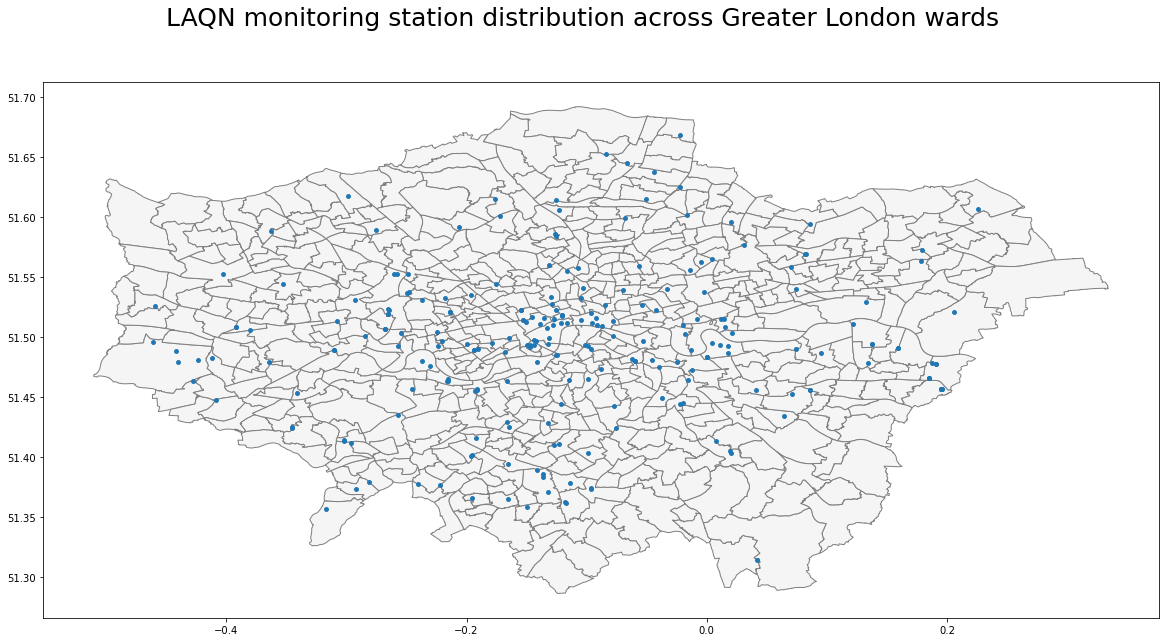

In [108]:
plot_on_map(site_gdf, london_wards_gdf, 
            title="LAQN monitoring station distribution across Greater London wards", 
            data_markersize=15,  
            map_edge_color="gray", axis="on")